In [1]:
%pylab inline
import poppy
import astropy.units as u
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12,4]

Populating the interactive namespace from numpy and matplotlib


# Sign Conventions for Coordinates, Phase, and Wavefront Error


_Thanks to Derek Sabatke (Ball Aerospace), Matt Bergkoetter, Alden Jurling, Tom Zielinski (NASA GSFC), and Randal Telfer (STScI) for invaluable discussions and contributions in disambiguating this oft-treacherous topic._

We begin by stating the basic conventions assumed for spatial and angular coordinates, then move on to the more subtle issues of wavefront error and optical propagation sign conventions. 


<div class="alert alert-info">
Summary: 
    
In brief, <tt>poppy</tt> as of version 1.0 and later uses sign conventions consistent with widely used optical engineering tools (Code V, Zemax, etc), in that <i>positive wavefront error corresponds to advanced phase (and to shorter optical path length)</i>.  Note that this convention is opposite that of the classic texts by Goodman or Born & Wolf.
    
To be consistent with this, forward propagation calculations use a positive sign in the Fourier transform's complex exponential. This is what is labeled the 'inverse' Fourier transform in numpy.     
</div>

## Spatial Coordinate Conventions for Optical Planes

`Poppy` adopts a right-handed coordinate system as follows. The $z$ axis is the optical axis of propagation, with $+z$ being in the direction of travel as usual. In the plane of an optic, the $+y$ axis is vertical upwards. Following the right hand rule, if looking from an image plane towards an object plane (i.e. looking "outward from the detector", in the $-z$ direction), the $+x$ axis points toward the right. 

<br clear='all' />
<img src="poppy_pupil_axes_convention.png" width=700 align='center' />
<br clear='all' />

This convention has the convenient property that the $+x$ and $+y$ axes are consistent with `matplotlib` display conventions, assuming you use the `origin="lower"` display option to set the image axes origin to lower left. This display setting is applied automatically in all display functions in `poppy`. 

We note this axes convention is generally consistent with many optical engineering packages. For instance, Code V uses a similar right-handed system, and for the typical case in which $+z$ is the propagation direction (and without any additional coordinate rotations added) the axes definitions are similar.

As noted elsewhere, the paradigm in `poppy` is to model "unfolded" optical systems, i.e. thinking of them in a linear fashion along the propagation direction "as if they were refractive". This intentionally simplifies away the change in physical propagation direction at reflective surfaces. 


**A note on reimaged pupils**: By convention and for convenience, `poppy` *by default models all pupils in a system on consistent axes matching that of the system exit pupil*; it does _not_ automatically model the inversion or flip at reimaged pupils (for Fraunhofer mode calculations). This is intended as a practical convenience to ease calculations on pupils without having to consider possibly-different coordinate signs for each successive pupil. If your use case requires modeling the spatial flip at reimaged pupils, add the coordinate inversion explicitly via a `poppy.CoordinateInversion` instance.   For instance, this is done in `webbpsf` since the convention for the JWST primary is to represent it as in entrance pupil orientation seen from in front of the telescope; a `CoordinateInversion` is used to flip this to the exit pupil orientation before the optical propagations in the optical system model. Similarly, any intermediate image planes in a system are modeled with coordinates consistent with the final image plane. 

**Image plane coordinates** follow a similar convention for the $+x$ and $+y$ axes, illustrated below. This typically also corresponds to the typical astronomical convention of "images as projected looking out onto the sky", and in particular matches the output image axes convention for the Hubble and JWST image processing pipelines (and the vast majority of astronomical software worldwide). Intuitively, imagine "being the detector" and looking out at the sky through the optical system, or equivalently "looking through a transparent detector" out at the sky. 


<br clear='all' />
<img src="poppy_image_axes_convention.png" width=700 align='center' />
<br clear='all' />


**Position Angles**: Rotation angles in an optical plane are defined increasing counterclockwise (seen looking in the $-z$ direction, as described just above). In other words a rotation from the $+x$ axis toward the $+y$ axis is positive. 

This definition is consistent with the common astronomical convention of measuring angles counterclockwise from North towards East as projected onto the sky. It's also consistent with the convention used by Wyant and Creath (their Figure 4B), who further note that it matches the convention used in various optical interferogram analyses packages. 



## Sign Conventions for Wavefront Error and Phase

   _The devil is in the details, and the details are all sign conventions. --Anonymous_


<div class="alert alert-info">
The signs used to represent propagation of a complex wavefront ultimately depends on entirely arbitrary choices, particularly for the time dependence of the complex exponential. We discuss below in more detail the history of choices made by different authors. Ultimately there is no "right or wrong" answer here; what matters is to be consistent internally within a given toolkit, and clearly document the choices made. 
</div>

We choose to follow the convention that _an advanced wavefront corresponds to a positive optical path difference_.  This follows e.g. [Wyant and Creath's Basic Wavefront Aberration Theory](https://wp.optics.arizona.edu/jcwyant/wp-content/uploads/sites/13/2016/08/03-BasicAberrations_and_Optical_Testing.pdf). We quote from their Section 1 on Sign Conventions:

> The optical path difference (OPD) is defined as the difference between the aberrated and the ideal unaberrated wavefronts. The OPD is positive if the aberrated wavefront leads the ideal unaberrated wavefront as shown in Fig. 2. Also, if the aberrated wavefront curves in more than the unaberrated wavefront, the OPD is positive. Therefore, a negative focal shift will introduce a positive aberration, so that a positive aberration will focus in front of the Gaussian image plane, as shown in Fig. 3. In the case of interferometric optical testing, this means that a bump on a test mirror (aberrated beam) will be represented by a bump in the OPD.


<BR clear='all' />
<img src="fig_wyant_creath_sign_convention_fig2.png" width=400 align='left' />
<img src="fig_wyant_creath_sign_convention_fig3.png" width=400 align='right' />
<BR clear='all' />


Thus in the case of a segmented telescope, advancing one segment forward (towards the secondary) should be represented as _positive_ wavefront error over the area of that segment. 


**Optical Path Difference vs. Optical Path Length:**

An alternative phrasing that arrives at the same place is as follows. We can define the *optical path length* (OPL) as the sum of distances across ray segments; this is intuitive, easy to calculate, and essentially free of sign conventions. With that definition in mind we can state: _A longer optical path length causes a ray’s phase to lag, so that corresponds to a negative wavefront error._ "Lag" in this context means that the propagation time is larger along that longer path. (This is equivalent to the choice of a positive sign for the harmonic time dependence, discussed below).  We can then relate:

```
OPD = WFE = aberrated_wavefront - unaberrated_wavefront = constant - OPL
```




## Sign conventions used in optical propagation 


The sign of the phase term in expressions for complex amplitude depends on the choice of an arbitrary sign in the complex exponential $exp[\pm i(\omega t - kr)]$, where $r$ is propagation distance and $k= 2 \pi /\lambda$.  So for an aberrated wave propagating roughly along the $z$ axis, we can say $r = z + OPL$.  The sign on OPL is unambiguous because optical path length behaves like propagation distance. Plugging that in gives $exp(\mp ik OPL) exp[\pm i(\omega t - kz)]$, which technically answers the question, but is not so helpful until clarifying if you're using the signs on the top or the bottom of the complex exponential. 

In the case of `poppy` we choose the top signs (increasing phase with time). It is then possible to work through the derivation of plane wave propagation via the angular spectrum method and find that the Fourier transform should have a positive sign in the exponent, for a basic left-to-right propagation from a real pupil to a real image.  


The [numpy sign convention for FFTs](https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft) uses a negative sign in the exponential for the "forward" transform `np.fft`, and a positive sign in the exponential for the "inverse" transform `np.ifft`. Thus we arrive at the conclusion that we need an inverse FFT for the forward propagation, and vice versa a forward FFT for backward propagation. 

We verify below that adopting this convention does result in PSFs consistent with expectations, in particular for tilts on wavefronts. 


### **Sign conventions for wavefront tilts:**

As a particular example, returning to Wyant and Creath, they state: 

> Tilt in a wavefront affects the image by causing a shift of its center location in the Gaussian image plane. A tilt causing a positive OPD change in the +x direction will cause the image to shift in the -x direction.

We demonstrate below this is the case for poppy, both for overall wavefront tilts and for individual tilted segments. 


### Historical aside: Why is all this so confusing anyway? 

As noted above, there is a truly arbitrary choice for the sign convention of the harmonic time dependence,  $exp[\pm i(\omega t - kr)]$. Different authors have chosen differently. 

 *  Goodman and Born & Wolf chose the convention that meaning a diverging spherical wave looks like $exp(ikr – i\omega t)$, and a converging spherical wave is $exp(-ikr – i\omega t)$. You can see the time dependence shown explicitly in Goodman’s Eq. 3-10, and in Born & Wolf's Section 8.3.1. 
 * Wyant & Creath and Code V adopted the other convention. Matthew Bergkoetter (NASA GSFC) speculates they adopted conventions following H.H. Hopkins. In particular the Code V documentation (the  ‘Near Field Propagation’ section of Chapter 2 of the Diffraction Analysis Reference Manual), the paper they cite for their PSF calculation is
[Hopkins and Yzuel 1970](https://doi.org/10.1080/713818292). In Eq. 1 of that paper, Hopkins starts his derivation with diverging spherical waves shown as $exp(-ikR’)$, which makes sense if he has a positive time dependence, i.e. $exp(-ikR’ + i\omega t)$. The effect this has can be seen later in that paper's Eq. 3, which is missing a negative sign in the exponent of the Fourier kernel, compared to Goodman’s formulas.



## Sign Convention Test Cases and Verifications

The remainder of this notebook presents test calculations to demonstrate consistencey with the above. Many of the test cases are repeated for both the Fraunhofer and Fresnel propagation algorithms.  


For displays of phase and/or OPD, poppy by default uses a diverging color table in which positive values are depicted in red and negative values in blue, as shown in the various plot colorbars below. 

### A converging wavefront has positive OPD

The OPD is positive if the aberrated wavefront leads the ideal unaberrated wavefront.  A converging wavefront leads at its outer edges relative to a flat wavefront. Here we create a converging wavefront and verify that it has positive wavefront aberration. 

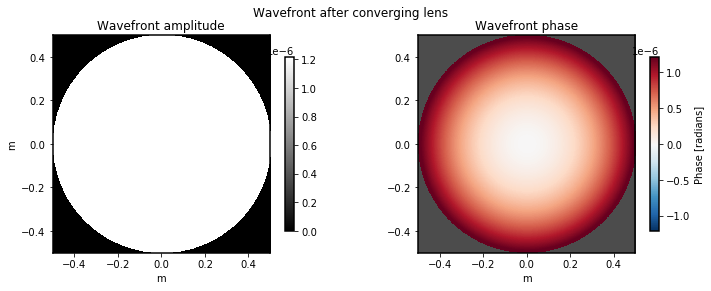

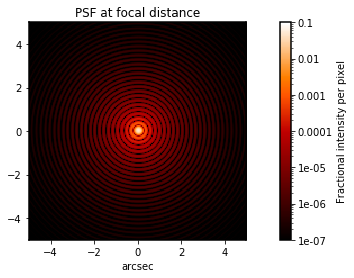

In [2]:
# Construct a converging optical system: 
focal_length = 1.0*u.m
osys = poppy.FresnelOpticalSystem(beam_ratio=0.25, pupil_diameter=1*u.m)
osys.add_optic(poppy.CircularAperture(radius=0.5*u.m))
lens = poppy.QuadraticLens(f_lens=focal_length, name="Converging lens")
osys.add_optic(lens)
osys.add_optic(poppy.ScalarTransmission(planetype=poppy.poppy_core.PlaneType.image, 
                                        name='focus'), 
               distance=focal_length);

psf, waves = osys.calc_psf(wavelength=1*u.micron, display=False, return_intermediates=True)

plt.figure()
waves[1].display(what='both', colorbar=True)
plt.suptitle("Wavefront after converging lens")

assert np.all(waves[1].phase[waves[1].intensity != 0] >= 0), "Converging wave should have all positive phase"

plt.figure()
poppy.display_psf(psf, imagecrop=10, title='PSF at focal distance')

### A positive lens has positive WFE

A fairly simple test, to show consistency of the ThinLens class with the above expectations. 

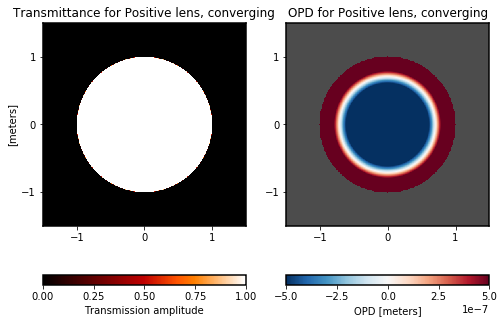

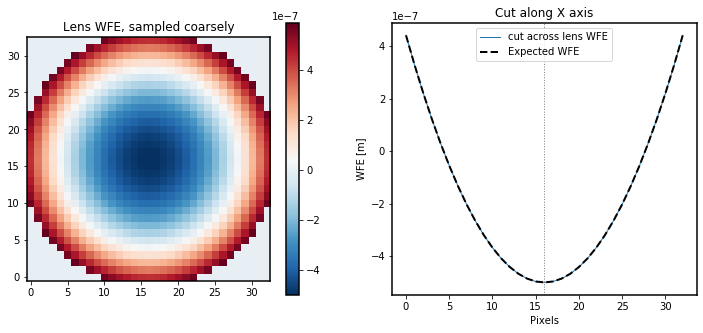

In [3]:
lens = poppy.ThinLens(name = "Positive lens, converging", radius=1)
plt.figure(figsize=(8,6))
lens.display(what='both')

wavelen = 1*u.micron
nwaves = 1
npix =33  # use odd number so it passes exactly through the origin
lens_opd = poppy.ThinLens(nwaves=nwaves, reference_wavelength=wavelen,
                          radius=1).sample(what='opd', npix=npix, grid_size=2)

fig, axes = plt.subplots(figsize=(12,5), ncols=2)
# Plot the lens WFE
axes[0].imshow(lens_opd, cmap=poppy.conf.cmap_diverging)
plt.colorbar(axes[0].images[0], ax=axes[0])
axes[0].set_title("Lens WFE, sampled coarsely")

# Plot a 1D cut through the lens WFE
axes[1].plot(lens_opd[lens_opd.shape[0]//2], label='cut across lens WFE')

# Plot the expected form of the lens WFE as a parabola
cen = (npix-1)//2
x = (np.arange(npix)-cen) / (npix/2)

y = nwaves*wavelen.to_value(u.m) * x**2
y += lens_opd.min()
axes[1].plot(y, ls='--', color='black', lw=2, label='Expected WFE')
axes[1].axvline(cen, ls=":", color='gray')
axes[1].set_xlabel("Pixels")
axes[1].set_ylabel("WFE [m]")
axes[1].set_title("Cut along X axis")
axes[1].legend()

assert np.allclose(lens_opd[lens_opd.shape[0]//2], y), "Lens WFE did not match expectations for a positive lens" 

# For a automated unit test version of this, see poppy.tests.test_sign_conventions.test_lens_wfe_sign

### OPD and WFE should have consistent signs and amplitudes

A positive bump on an optic (or, equivalently, a positive perturbation on a segmented or deforamable mirror) should produce positive wavefront error in a beam that encounters that optic. 

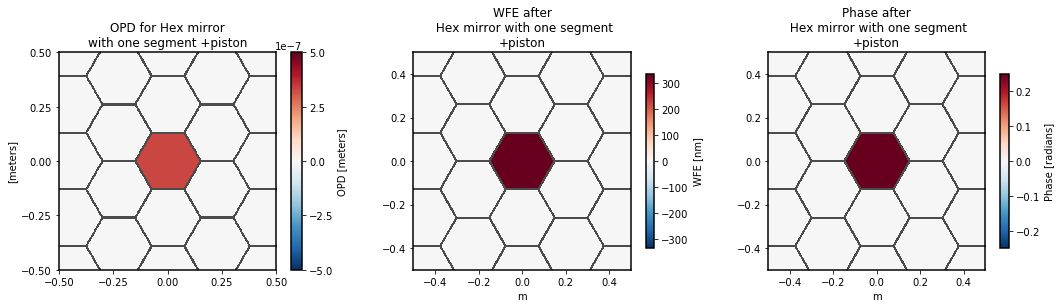

In [4]:
wavelen = 1*u.micron

hexdm = poppy.HexSegmentedDeformableMirror(flattoflat=0.25*u.m, name='Hex mirror\nwith one segment +piston')
hexdm.set_actuator(0, wavelen/3, 0, 0 )  # apply some piston < 1/2 wave to avoid phase ambiguity

osys2 = poppy.OpticalSystem(pupil_diameter=1*u.m)
osys2.add_pupil(poppy.CircularAperture(radius=0.5*u.m))
osys2.add_pupil(hexdm)

wave = osys2.input_wavefront()
wave *= hexdm

fig, axes = plt.subplots(figsize=(18,4), ncols=3)

# Display hex DM (zoomed in)
hexdm.display(what='opd', npix=1024, ax=axes[0], colorbar_orientation='vertical')
axes[0].set_xlim(-0.5, 0.5)
axes[0].set_ylim(-0.5, 0.5)

# display wavefront, as WFE and phase
wave.display(what='wfe', colorbar=True, ax=axes[1], )
wave.display(what='phase', colorbar=True, ax=axes[2])

# Assert consistency
opd = hexdm.get_opd(wave)
where_valid = opd != 0
assert np.allclose(opd[where_valid].mean(), wave.wfe[where_valid].mean().value), \
    "OPD and WFE should be consistent, for cases avoiding phase wrapping"

# For a related automated unit test, see poppy.tests.test_sign_conventions.test_wfe_opd_consistency

### A wavefront with positive OPD tilt in +x should shift the focused PSF toward -x

We perform this test twice, verifying expected behavior for both Fraunhofer and Fresnel propagation methods. 

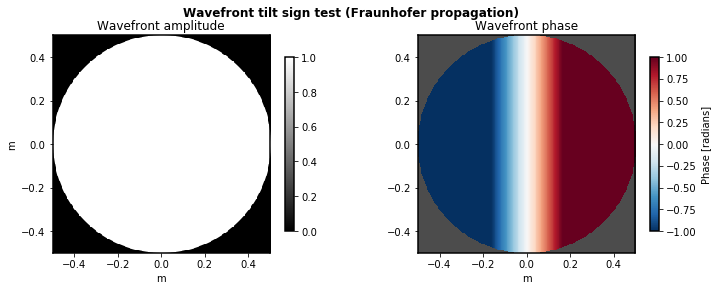

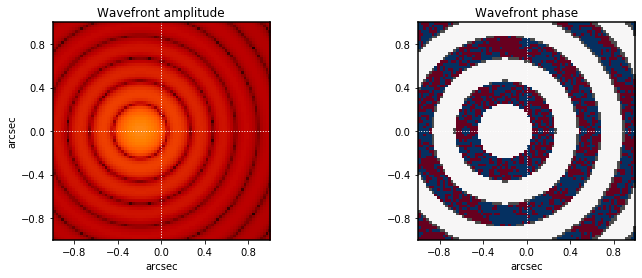

In [5]:
plt.suptitle("Wavefront tilt sign test (Fraunhofer propagation)", fontweight='bold')
# Create a wavefront and apply a tilt
wave = poppy.Wavefront(diam=1*u.m, npix=256)
wave *= poppy.CircularAperture(radius=0.5*u.m)
    
tilt_angle = -0.2    # must be a negative number (for -X direction shift), and within the FOV

wave.tilt(Xangle=tilt_angle)  # for this function, the input is the desired direction for the image to tilt.
                              # A shift to -X is implemented by creating an OPD that increases toward +X
n = wave.shape[0]
assert wave.wfe[n//2, n//2-5] <  wave.wfe[n//2, n//2+5], "Wavefront error should increase to +X"

wave.display(what='both', colorbar=True,)

wave.propagate_to(poppy.Detector(pixelscale=0.025, fov_pixels=256))

plt.figure()
wave.display(what='both', crosshairs=True, imagecrop=2)

n = wave.shape[0]
cen = poppy.measure_centroid(wave.as_fits())
assert np.allclose(cen[0], (n-1)/2), "Tilt in X should not displace the PSF in Y"
assert cen[1] < (n-1)/2, "WFE tilt increasing to +X should displace the PSF to -X"
assert np.allclose(((cen[1]-(n-1)/2)*u.pixel*wave.pixelscale).to_value(u.arcsec), tilt_angle), "PSF offset did not match expected amount"


# For a automated unit test version of this, see poppy.tests.test_sign_conventions.test_wavefront_tilt_sign_and_direction

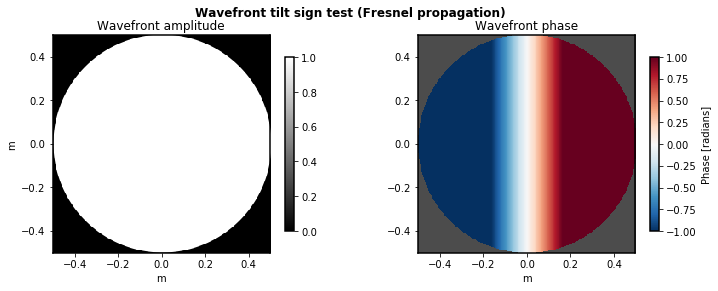

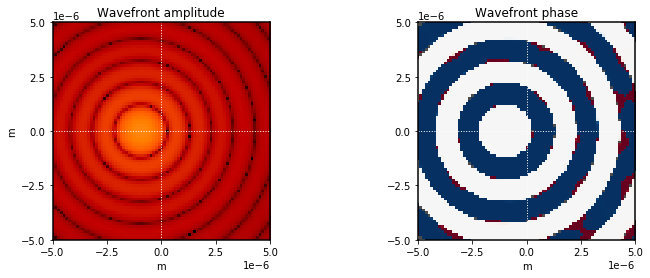

In [6]:
plt.suptitle("Wavefront tilt sign test (Fresnel propagation)", fontweight='bold')
# Create a wavefront and apply a tilt
wave = poppy.FresnelWavefront(beam_radius=0.5*u.m, npix=256, oversample=8)
wave *= poppy.CircularAperture(radius=0.5*u.m)
    
# tilt in arcseconds
tilt_angle = -0.2    # must be a negative number (for -X direction shift), and within the FOV

wave.tilt(Xangle=tilt_angle)  # for this function, the input is the desired direction for the image to tilt.
                              # A shift to -X is implemented by creating an OPD that increases toward +X
n = wave.shape[0]
assert wave.wfe[n//2, n//2-5] <  wave.wfe[n//2, n//2+5], "Wavefront error should increase to +X"

wave.display(what='both', colorbar=True)


focal_length = 1*u.m
wave *= poppy.QuadraticLens(f_lens=focal_length)

wave.propagate_fresnel(focal_length)

plt.figure()
wave.display(what='both', crosshairs=True, imagecrop=0.00001, scale='log')

n = wave.shape[0]
nominal_cen = n//2   # In Fresnel mode, PSFs are centered on a pixel by default 
                      # (different from in Frauhofer mode by half a pixel)

cen = poppy.measure_centroid(wave.as_fits())
assert np.allclose(cen[0], nominal_cen), "Tilt in X should not displace the PSF in Y"
assert cen[1] < nominal_cen, "WFE tilt increasing to +X should displace the PSF to -X"
assert np.allclose((cen[1]-nominal_cen)*u.pixel*wave.pixelscale,
            (tilt_angle*u.arcsec).to_value(u.radian)*focal_length), "PSF offset distance did not match expected amount"

# For a automated unit test version of this, see poppy.tests.test_sign_conventions.test_wavefront_tilt_sign_and_direction_fresnel

### A tilted segment with positive OPD tilt in +x should shift its focused PSF toward -x

A more complicated example, with multiple tilted segments in a deformable mirror. We tilt one segment to move its spot toward $-x$, and another to move its spot toward $-y$ by half the amount. 

We again perform this test twice, verifying expected behavior for both Fraunhofer and Fresnel propagation methods. 

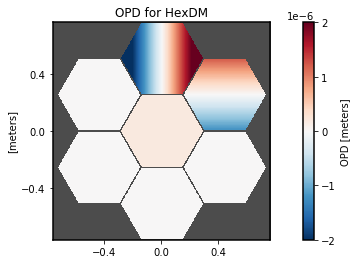

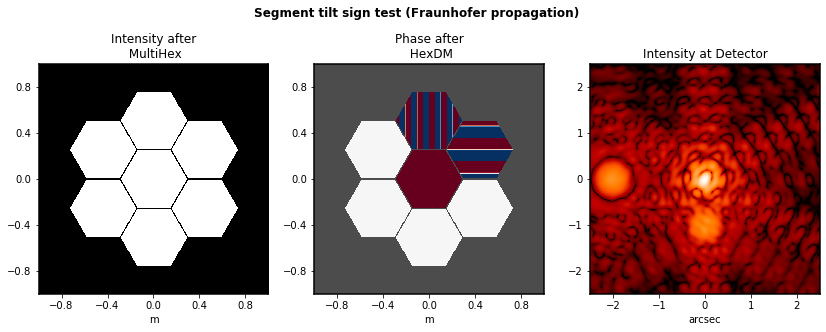

In [7]:
hexdm = poppy.HexSegmentedDeformableMirror(flattoflat=0.5*u.m, rings=1)
hexdm.set_actuator(0, 0.2*u.micron, 0, 0)  # piston
hexdm.set_actuator(1, 0, 2*u.arcsec, 0)    # tip
hexdm.set_actuator(2, 0, 0, 1*u.arcsec)    # tilt


osys2 = poppy.OpticalSystem(pupil_diameter=2*u.m)
#osys2.add_pupil(poppy.CircularAperture(radius=0.4*u.m))
osys2.add_pupil(poppy.MultiHexagonAperture(flattoflat=0.5*u.m, rings=1, center=True))
osys2.add_pupil(hexdm)
osys2.add_detector(0.010, fov_arcsec=10)


hexdm.display(what='opd', colorbar_orientation='vertical', opd_vmax=2e-6)

plt.figure(figsize=(14,5))
plt.suptitle("Segment tilt sign test (Fraunhofer propagation)", fontweight='bold')
psf2, waves = osys2.calc_psf(display_intermediates=True, return_intermediates=True)

# For a automated unit test version of this, see poppy.tests.test_sign_conventions.test_segment_tilt_sign_and_direction

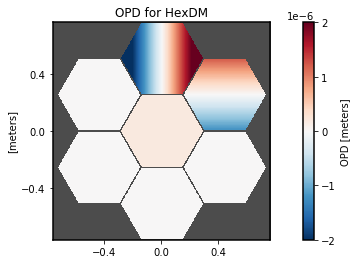

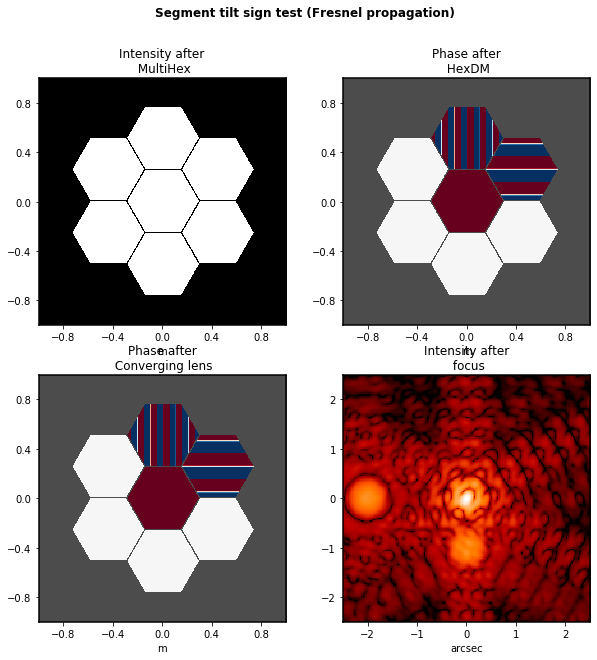

In [8]:
# Same thing, in Fresnel:
hexdm = poppy.HexSegmentedDeformableMirror(flattoflat=0.5*u.m, rings=1)
hexdm.set_actuator(0, 0.2*u.micron, 0, 0)  # piston
hexdm.set_actuator(1, 0, 2*u.arcsec, 0)    # tip
hexdm.set_actuator(2, 0, 0, 1*u.arcsec)    # tilt


focal_length = 1.0*u.m
osys3 = poppy.FresnelOpticalSystem(pupil_diameter=2*u.m, beam_ratio=0.25)
osys3.add_optic(poppy.MultiHexagonAperture(flattoflat=0.5*u.m, rings=1, center=True))
osys3.add_optic(hexdm)
lens = poppy.QuadraticLens(f_lens=focal_length, name="Converging lens")
osys3.add_optic(lens)
osys3.add_optic(poppy.ScalarTransmission(planetype=poppy.poppy_core.PlaneType.image, 
                                        name='focus'), 
               distance=focal_length);


hexdm.display(what='opd', colorbar_orientation='vertical', opd_vmax=2e-6)
plt.figure(figsize=(10,10))
plt.suptitle("Segment tilt sign test (Fresnel propagation)", fontweight='bold')
psf2, waves = osys3.calc_psf(display_intermediates=True, return_intermediates=True)

### Additional positive focus WFE moves the focus earlier (towards -z), and vice versa

We verify here that: 

1. A negative weak lens produces images (before focus) that have consistent orientation with the exit pupil
2. A positive weak lens produces images (after focus) that have the opposite orientation as the exit pupil
3. Images with the same magnitude but opposite signs of defocus should be 180 degree rotations of one another (for the simple case with no wavefront error).
    
We can do this with a letter-F shaped aperture for the parity test. 

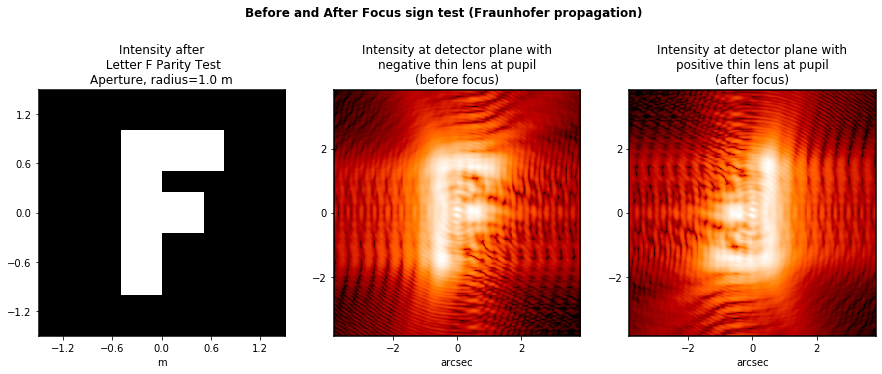

In [9]:
fig, axes = plt.subplots(figsize=(15,6), ncols=3)
plt.suptitle("Before and After Focus sign test (Fraunhofer propagation)", fontweight='bold')

wave = poppy.Wavefront(diam=3*u.m)
wave *= poppy.LetterFAperture()
wave.display(ax=axes[0])
wave0 = wave.copy()
wave2 = wave.copy()

wave *= poppy.ThinLens(nwaves=-5)
wave.propagate_to(poppy.Detector(fov_pixels=256, pixelscale=0.03*u.arcsec/u.pixel))
wave.display(imagecrop=30, ax=axes[1],
             title='Intensity at detector plane with\nnegative thin lens at pupil\n(before focus)')

wave2 *= poppy.ThinLens(nwaves=+5)
wave2.propagate_to(poppy.Detector(fov_pixels=256, pixelscale=0.03*u.arcsec/u.pixel))
wave2.display(imagecrop=30, ax=axes[2],
              title='Intensity at detector plane with\npositive thin lens at pupil\n(after focus)')


def brighter_top_half(image):
    s = image.shape
    top = image[s[0]//2:].sum()
    bot = image[:s[0]//2].sum()
    return top > bot

def brighter_left_half(image):
    return not brighter_top_half(image.transpose())

assert brighter_top_half(wave0.intensity) and brighter_left_half(wave0.intensity), "Letter F should be brighter at top and left"
assert brighter_top_half(wave.intensity) and brighter_left_half(wave.intensity), "Image with negative lens (before focus) should have same orientation as the pupil "
assert (not brighter_top_half(wave2.intensity)) and (not brighter_left_half(wave2.intensity)), "Image with positive lens (after focus) should have opposite orientation as the pupil "

# For a automated unit test version of this, see poppy.tests.test_sign_conventions.test_pupil_orientations_before_and_after_focus

For the Fresnel version of this test, we do this slightly different than the test just above for Fraunhofer mode:  Rather than adding focus to move the image forward and back relative to the detector, we simply test propagation directly to distances slightly different from the focal length.  

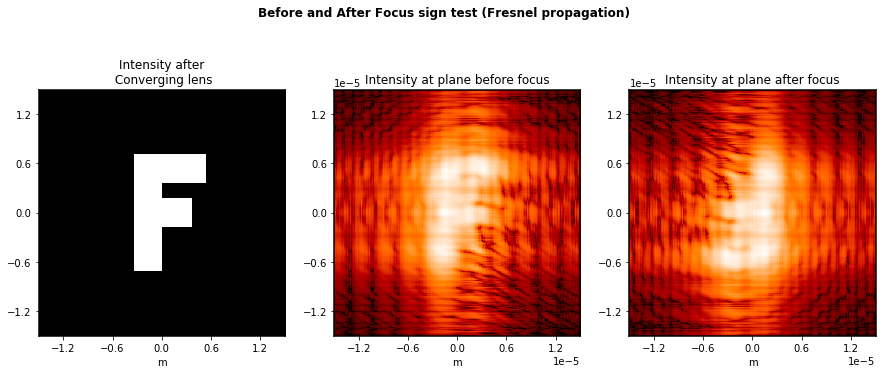

In [10]:
fig, axes = plt.subplots(figsize=(15,6), ncols=3)
plt.suptitle("Before and After Focus sign test (Fresnel propagation)", fontweight='bold')


wave0 = poppy.FresnelWavefront(beam_radius=1.5*u.m, oversample=2)
wave0 *= poppy.LetterFAperture(radius = 1/np.sqrt(2)*u.m)

focal_length = 1.0*u.m
lens = poppy.QuadraticLens(f_lens=focal_length, name="Converging lens")
wave0 *= lens

wave0.display(ax=axes[0])
wave1 = wave0.copy()
wave2 = wave0.copy()

fov = 0.00003

wave1.propagate_fresnel(0.99999*focal_length)
wave1.display(imagecrop=fov, title='Intensity at plane before focus', scale='log', ax=axes[1])

wave2.propagate_fresnel(1.00001*focal_length)
wave2.display(imagecrop=fov, title='Intensity at plane after focus', scale='log', ax=axes[2])

assert brighter_top_half(wave0.intensity) and brighter_left_half(wave0.intensity), "Letter F should be brighter at top and left at pupil"
assert brighter_top_half(wave1.intensity) and brighter_left_half(wave1.intensity), "Image with negative lens (before focus) should have same orientation as the pupil "
assert (not brighter_top_half(wave2.intensity)) and (not brighter_left_half(wave2.intensity)), "Image with positive lens (after focus) should have opposite orientation as the pupil "

# For a automated unit test version of this, see poppy.tests.test_sign_conventions.test_pupil_orientations_before_and_after_focus_fresnel

### Before and After focus, again but with a phase rather than amplitude pattern this time. 

Variation on the above tests, using a letter-F made with OPD rather than with amplitude. As expected, this is consistent too. 

Once again we repeat this test for both propagation methods. 

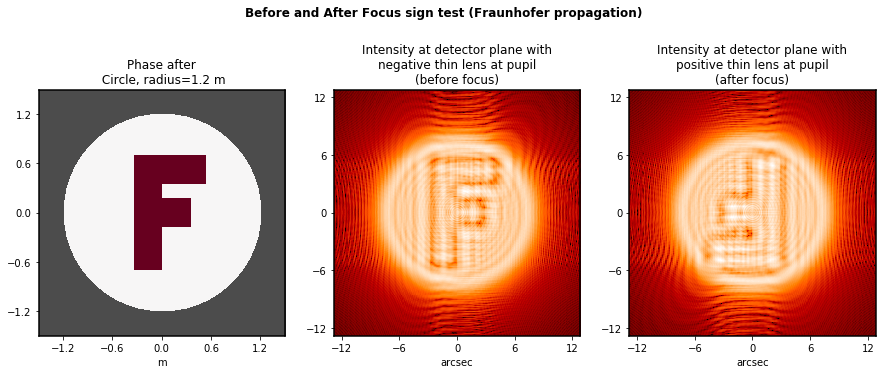

In [11]:
fig, axes = plt.subplots(figsize=(15,6), ncols=3)
plt.suptitle("Before and After Focus sign test (Fraunhofer propagation)", fontweight='bold')

wave = poppy.Wavefront(diam=3*u.m)
wave *= poppy.optics.LetterFOpticalPathDifference(opd=0.25*u.micron, radius=0.7*u.m)
wave *= poppy.CircularAperture(radius=1.2*u.m)
wave.display(ax=axes[0], what='phase')
wave0 = wave.copy()
wave2 = wave.copy()

wave *= poppy.ThinLens(nwaves=-20)
wave.propagate_to(poppy.Detector(fov_pixels=256, pixelscale=0.1*u.arcsec/u.pixel))
wave.display(imagecrop=30, ax=axes[1],
             title='Intensity at detector plane with\nnegative thin lens at pupil\n(before focus)')

wave2 *= poppy.ThinLens(nwaves=+20)
wave2.propagate_to(poppy.Detector(fov_pixels=256, pixelscale=0.1*u.arcsec/u.pixel))
wave2.display(imagecrop=30, ax=axes[2],
              title='Intensity at detector plane with\npositive thin lens at pupil\n(after focus)')

# TODO - Not sure how to easily write a simple check for correctness of this; the human eye does it
# easily but how to do in Python without invoking a large detour into machine vision? 

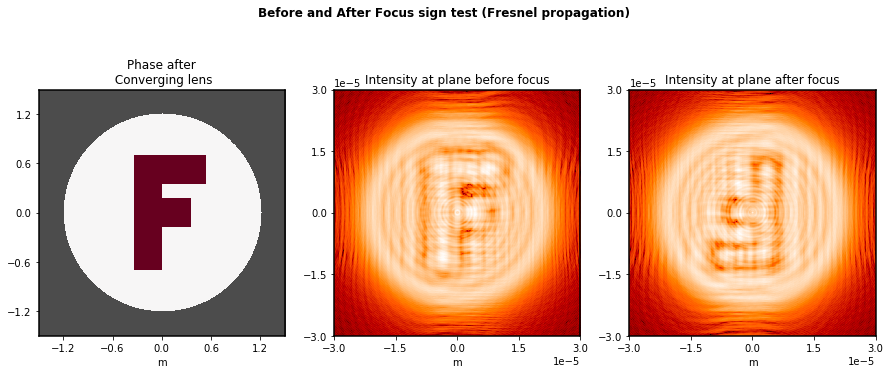

In [12]:
fig, axes = plt.subplots(figsize=(15,6), ncols=3)
plt.suptitle("Before and After Focus sign test (Fresnel propagation)", fontweight='bold')


wave0 = poppy.FresnelWavefront(beam_radius=1.5*u.m, oversample=2)
wave0 *= poppy.optics.LetterFOpticalPathDifference(opd=0.25*u.micron, radius=0.7*u.m)
wave0 *= poppy.CircularAperture(radius=1.2*u.m)

focal_length = 1.0*u.m
lens = poppy.QuadraticLens(f_lens=focal_length, name="Converging lens")
wave0 *= lens

wave0.display(ax=axes[0], what='phase')
wave1 = wave0.copy()
wave2 = wave0.copy()

fov = 0.00006

wave1.propagate_fresnel(0.99998*focal_length)
wave1.display(imagecrop=fov, title='Intensity at plane before focus', scale='log', ax=axes[1])

wave2.propagate_fresnel(1.00002*focal_length)
wave2.display(imagecrop=fov, title='Intensity at plane after focus', scale='log', ax=axes[2])

# TODO - Not sure how to easily write a simple check for correctness of this; the human eye does it
# easily but how to do in Python without invoking a large detour into machine vision? 